Hess Data Set 
=============

In [1]:
from collections import OrderedDict
import itertools
import numpy as np
import pandas as pd
import plotnine
from plotnine import ggplot, aes, facet_wrap, geom_point, stat_smooth, scale_x_log10
plotnine.theme_set(plotnine.theme_bw())
import sklearn as sk

from maclearn_utils_2020 import extractPCs

The Hess data set I initially mentioned in the introductory notes
consists of microarray data taken from fine-needle biopsies taken from
breast cancer patients. A number of patient characteristics were
collected, but the main focus of the modeling that we will be
doing---like the modeling that Hess et al. were doing!
([@hess2006pharmacogenomic])---will be the sensivity to
preoperative chemotherapy, with the patients divided into those who
exhibited residual disease (RD) or those who did not and were thus
classified as have pathologic complete response (pCR) to chemotherapy.
In order to load the Hess data in, let's re-define the function `rt`
we used to load the Neves data in before:

In [2]:
 ## define convenience function for loading tabular data
 ## (just using read.table with different default options)
def rt(f):
    return pd.read_csv(f, sep="\t", index_col=0, header=0)

Hess et al. obtained two separate data sets, a training set which they
used to develop a classifier for RD-vs-pCR, and a test set which they
used to assess the performance of the resulting classifier. Let's load
in the training data first:

In [3]:
 ## training set:
hessTrain = rt("data/HessTrainingData.tsv.gz")
hessTrainAnnot = rt("data/HessTrainingAnnotation.tsv")
 ## align annotation data.frame with expression data:
hessTrainAnnot = hessTrainAnnot.loc[hessTrain.columns]

And now the test data:

In [4]:
 ## test set:
hessTest = rt("data/HessTestData.tsv.gz")
hessTestAnnot = rt("data/HessTestAnnotation.tsv")
 ## align annotation data.frame with expression data:
hessTestAnnot = hessTestAnnot.loc[hessTest.columns]

Taking a quick look at the training data:

In [5]:
hessTrain.iloc[0:5, 0:5]

,M157,M196,M176,M214,M113
ProbeSet,,,,,
AFFX-BioB-5_at,8.944566,8.377514,8.386897,8.292460,8.531966
AFFX-BioB-M_at,9.852639,9.342453,9.499607,9.295769,9.343919
AFFX-BioB-3_at,9.862932,9.237090,9.476301,9.290295,9.364047
AFFX-BioC-5_at,10.108551,9.489507,9.475409,9.355395,9.378707
AFFX-BioC-3_at,10.317820,9.594679,9.841014,9.678230,9.595369


we see that the rows here are not annotated by gene ids but instead by
*probe set* ids. We'll load in the microarray probe annotations
mapping these probe sets back to genes as well:

In [6]:
probeAnnot = rt("data/U133A.tsv.gz")
 ## align hessTrain and hessTest to probeAnnot:
hessTrain = hessTrain.loc[probeAnnot.index]
hessTest = hessTest.loc[probeAnnot.index]

For ease of classification using `sklearn`, we'd like to extract the
class labels from columns of the sample annotation files into
0-1 numeric `pd.Series` variables:

In [7]:
hessTrainY = pd.Series({"pCR":0, "RD":1}).loc[hessTrainAnnot["pCRtxt"]]
hessTrainY.index = hessTrainAnnot.index
hessTestY = pd.Series({"pCR":0, "RD":1}).loc[hessTestAnnot["pCRtxt"]]
hessTestY.index = hessTestAnnot.index

Finally, let's take a quick look at the test and training set data put
together via a PCA plot:

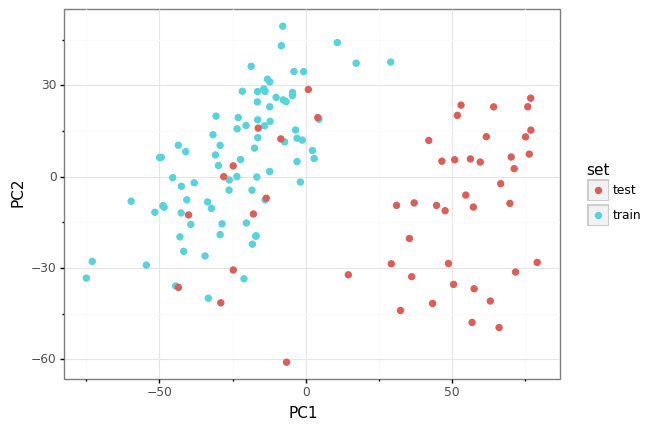

<ggplot: (8763088078252)>


In [8]:
 ## use pd.concat to column-bind the training and test data sets together:
combinedData = pd.concat([hessTrain, hessTest], axis=1)
pca = extractPCs(combinedData.T)
ggdata = pd.DataFrame({
    "PC1" : pca.x[:, 0],
    "PC2" : pca.x[:, 1],
    "set" : ["train"]*len(hessTrainY) + ["test"]*len(hessTestY)
})
gg = ggplot(ggdata, aes(x="PC1", y="PC2", color="set"))
gg += geom_point(size=2)
print(gg)

This shows an uncomfortable fact about real-world applications of
machine learning: when training and test sets are collected
separately, there tend to be systematic differences between them. This
can result in degraded test-set performance even when models have been
carefully constructed using the most effective algorithms available!

$k$-Nearest Neighbors (knn) 
=========================================

The $k$-neighest neighbors, or knn, algorithm
([@cover1968estimation]) is a particularly simple and democratic
approach to classification:
To classify sampling unit $i$ with feature values $x_ig$:
-   find the $k$ sampling units $\{j_1, j_2, \ldots, j_k\}$ from the
    training set *most similar* to $i$: these are the "nearest
    neighbors"
-   calculate the fraction $\frac{\sum_b y_{j_b}}{k}$ of the nearest
    neighbors which have $y_{j_{b}} = 1$: this is the knn model-predicted probability
    that $y_i = 1$.

In [9]:
 ## extract vector of gene expression values for test sample 1:
featuresForTestSample1 = hessTest.iloc[:, 0]
 ## calculate distance of each training sample from first test sample:
 ## note: subtraction of vector from matrix is row-wise in Python!
euclideanDistancesFromTrainSamples = np.sqrt(
    ( (hessTrain.T - featuresForTestSample1)**2 ).sum(axis=1)
)
 ## what are the 9 nearest neighbors
 ## and their distances from first test sample?
nn = euclideanDistancesFromTrainSamples.sort_values()[0:9]
nn

M205    75.765724
M154    83.927347
M133    85.010141
M211    88.525863
M206    88.736769
M111    89.501074
M180    89.543348
M136    89.967441
M179    93.139498
dtype: float64

In [10]:
 ## what are their classifications?
hessTrainY.loc[nn.index]

M205    0
M154    1
M133    1
M211    0
M206    0
M111    0
M180    0
M136    0
M179    0
dtype: int64

In [11]:
 ## 9-nn model predicted probability of RD for first test sample is:
np.sum( hessTrainY.loc[nn.index] ) / 9.0

0.2222222222222222

Here I should hasten to point out that all of the ML algorithms we
will study here have been been packaged up into more efficient and
user-friendly Python routines, so there is really no need to go
through the pain of re-implementing them from scratch! (I just wanted
to give you a sense of how simple knn in particular is ``under the
hood.'')

Here is the way I would actually suggest to apply the knn algorithm in
Python (using `sklearn.neighbors.KNeighborsClassifier`):

In [12]:
import sklearn.neighbors as nbr
 ## fit model object obtained by running
 ## (remembering sklearn wants features-in-columns):
knnFit = nbr.KNeighborsClassifier(n_neighbors=9)\
            .fit(hessTrain.T, hessTrainY)
 ## can then generate test set predictions using knnFit:
knnTestPredictionProbs = knnFit.predict_proba(hessTest.T)
 ## sklearn predict_proba will always produce matrix:
knnTestPredictionProbs[0:5, :]

array([[0.77777778, 0.22222222],
       [0.22222222, 0.77777778],
       [0.22222222, 0.77777778],
       [0.22222222, 0.77777778],
       [0.33333333, 0.66666667]])

In [13]:
 ## what is predicted probability RD for first test sample again?
knnTestPredictionProbs[0, 1]

0.2222222222222222

With sklearn, probabilitistic prediction is done using `predict_proba`,
while predicted classifications may be computed using the plain
`predict` method.

In [14]:
knnTestPredictionClass = knnFit.predict(hessTest.T)
knnTestPredictionClass[0:5]

array([0, 1, 1, 1, 1])

In [15]:
 ## use pd.crosstab to generate 2x2 contingency table:
contingency = pd.crosstab(knnTestPredictionClass, hessTestY,
                          rownames=["prediction"], colnames=["actual"])
contingency

actual,0,1
prediction,,
0,3,2
1,10,36


The 2x2 contingency table is a very useful and commonly presented
summary of binary classification results. If one class is regarded as
"positive" and one as "negative," the various cells of the 2x2
table can be labeled:

  |                 | Actual (-)             | Actual (+)            |
  |-----------------|------------------------|-----------------------|
  | Predicted (-)   | True Negatives (TN)    | False Negatives (FN)  |
  | Predicted (+)   | False Positives (FP)   | True Positives (TP)   |

Notice that:
-   the diagonal elements of the contingency table correspond to
    accurate classifications, and that
-   every (classifiable) sampling unit will fall into one of the
    four cells.

Thus we can calculate the fraction of sampling units classified
correctly---referred to in ML contexts as the *accuracy* of the
model fit---by dividing the sum of the diagonals of the contingency
table by the sum of all four entries in the contingency table:

In [16]:
estimatedAccuracy = np.sum(np.diag(contingency)) / np.sum(np.sum(contingency))
estimatedAccuracy

0.7647058823529411

Overfitting 
===========

Let's use the data for two specific microarray probes,
205548_s_at and 201976_s_at to fit a knn model with $k=27$:

In [17]:
 ## we'll go ahead and transpose the data.frame to have
 ## features-in-columns for convenience:
twoProbeData = hessTrain.T.loc[:, ["205548_s_at", "201976_s_at"]].copy()
 ## let's use friendlier gene names instead of probe ids here:
twoProbeData.columns =\
        probeAnnot.loc[twoProbeData.columns, "Gene.Symbol"]
twoProbeFitK27 = nbr.KNeighborsClassifier(n_neighbors=27)\
                    .fit(twoProbeData, hessTrainY)

I'm using two probes because I want to be able to make a contour plot
of the *decision boundary* of the knn classifier. I'm gonig to
use a function saved in the file `ggfuntile.py` to do this:

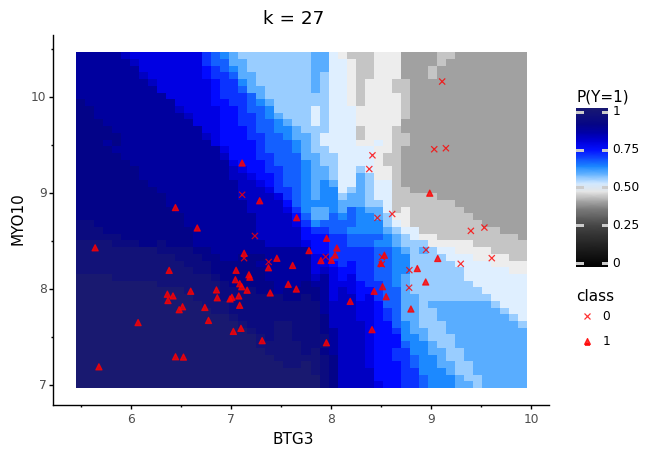

<ggplot: (8763008521117)>

In [18]:
from ggfuntile import predictionContour
 ## unfortunately plotnine doesn't support geom_contour,
 ## so Python predictionContour is somewhat misnamed!
predictionContour(twoProbeFitK27, twoProbeData, hessTrainY, "k = 27")

Looking at this decision boundary you might think this classifier
looks too conservative about calling pCR: Surely we could push that
boundary to the left a bit to catch a few more of those open
downward-pointing triangles? Thinking about this a bit more, it seems
that perhaps our choice of parameter $k=27$ is a bit high; after all,
27 is almost a third of all 82 samples in the
Hess training set. The appropriate neighborhood for points in the
upper right hand corner of the contour plot may be better estimated
with a more local knn model defined by, say, $k=9$:

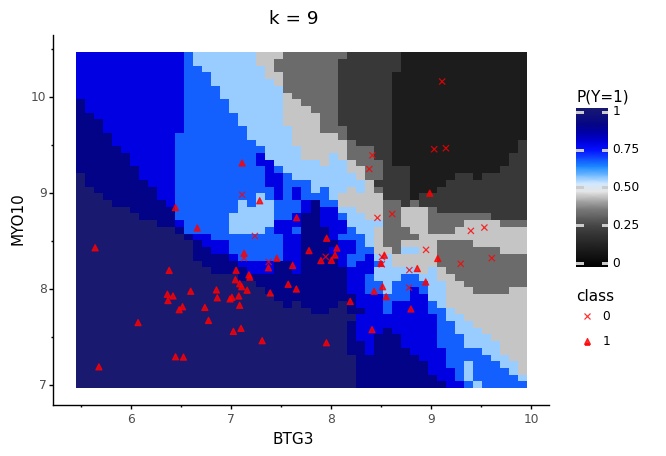

<ggplot: (8763008538561)>

In [19]:
twoProbeFitK9 = nbr.KNeighborsClassifier(n_neighbors=9)\
                   .fit(twoProbeData, hessTrainY)
predictionContour(twoProbeFitK9, twoProbeData, hessTrainY, "k = 9")

That does look somewhat better! Many more pCR samples correctly called
at the cost of only one extra misclassified RD sample. But perhaps we
could do better still with an even more local model---let's try $k=3$:

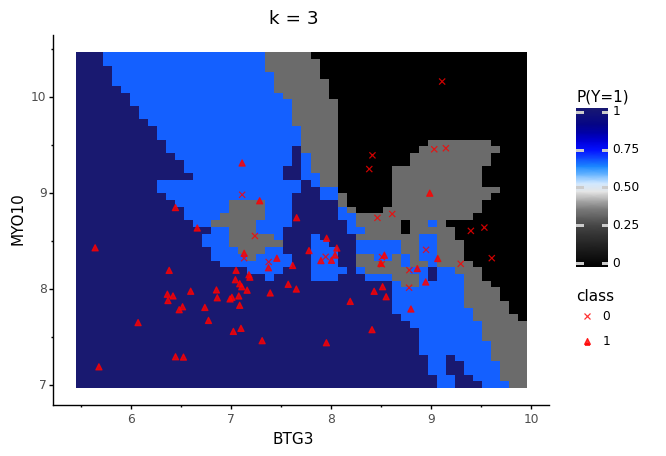

<ggplot: (8763030761957)>

In [20]:
twoProbeFitK3 = nbr.KNeighborsClassifier(n_neighbors=3)\
                   .fit(twoProbeData, hessTrainY)
predictionContour(twoProbeFitK3, twoProbeData, hessTrainY, "k = 3")

Hmmm\...this does appear to catch a few more pCR samples from the
training set, but we seem to have generated some swiss cheese-like
holes in the RD predicted region, along with a very convoluted bay
and peninsula in the center right portion of the main decision
boundary. Still, this seems like a very subjective complaint---let's
look at some accuracy estimates:

In [21]:
 ## define pair of convenience functions to minimize repeated code:
def contingencize(knnFit, data, y):
    return pd.crosstab(knnFit.predict(data), y,
                       rownames=["prediction"], colnames=["actual"])

def estimateAccuracyFrom2x2(twoByTwo):
    return np.sum(np.diag(twoByTwo)) / np.sum(np.sum(twoByTwo))

twoByTwo27 = contingencize(twoProbeFitK27, twoProbeData, hessTrainY)
estimateAccuracyFrom2x2(twoByTwo27)

0.8048780487804879

In [24]:
twoByTwo9 = contingencize(twoProbeFitK9, twoProbeData, hessTrainY)
estimateAccuracyFrom2x2(twoByTwo9)

0.8780487804878049

In [23]:
twoByTwo3 = contingencize(twoProbeFitK3, twoProbeData, hessTrainY)
estimateAccuracyFrom2x2(twoByTwo3)

0.8902439024390244

So does this really mean the swiss-cheese decision region is the
best\...?

Of course not! All of the accuracy estimates we just made suffer from
what's called *resubstitution bias* because we tested the model
on the same data set that was used to train it. Let's clean that up:

In [25]:
 ## extract test data for our two favorite probes...
twoProbeTest = hessTest.T.loc[:, ["205548_s_at", "201976_s_at"]]
twoProbeTest.columns =\
        probeAnnot.loc[twoProbeTest.columns, "Gene.Symbol"]
 ## now let's take another stab at accuracy estimations:
twoByTwo27 = contingencize(twoProbeFitK27, twoProbeTest, hessTestY)
estimateAccuracyFrom2x2(twoByTwo27)

0.7450980392156863

In [26]:
twoByTwo9 = contingencize(twoProbeFitK9, twoProbeTest, hessTestY)
estimateAccuracyFrom2x2(twoByTwo9)

0.803921568627451

In [27]:
twoByTwo3 = contingencize(twoProbeFitK3, twoProbeTest, hessTestY)
estimateAccuracyFrom2x2(twoByTwo3)

0.7647058823529411

While we may be a bit disappointed to see that the best accuracy
estimate from the test set is worse than the worst accuracy estimate
from resubstitution of the training set, we can find solace in noting
that the $k=3$ model with it's bizarre decision boundary is no longer
judged the best.

This is the classic problem of *overfitting*: Models with more
freedom to fit very complex patterns in the training data set---such
as our very local low-$k$ knn model---have a tendency to find
"signals" which are not reproducible in independent data sets, even
those of a very similar nature.

Here's an example where you can see the overfitting coming without any
computation at all: What do you think the resubstitution accuracy of a
1-nearest neighbor model would be? As a hint, you might think about what
the nearest neighbor of training sample $i$ is in the training set\...

knn Simulation 
==============

At this point I will digress away from analysis of the Hess microarray
data for a bit to consider simulated data sets. Simulated data can be
useful because:
1.  we know the true model used to generate the data exactly, and
2.  we can systematically vary any parameters that appear in the
    data generation model so as to study how well our ML algorithms work
    in a range of situations.

Let's define a function `simulate2group` for simulating
-   a simple data set with Rn sampling units (or simulated samples)
    and `m` features (simulated genes, if you like),
-   with the sampling units divided into two groups A and B,
-   and `mEffected` $\leq$ `m` of the features being shifted by
    `effectSize` units on average in group B relative to group A:

In [28]:
def simulate2group(n = 100,   ## number simulated samples
                   m = 1000,  ## number simulated genes
                   nA = None, ## first nA samples = group A
                              ## last (n-nA) samples = group B
                   mEffected = 10,    ## first mEffected genes will have
                                      ## different expression in group B
                   effectSize = 1 ## how many expression units difference
                                  ## between groups for mEffected genes
                   ):
    if nA is None:
        nA = int(np.ceil(0.5*n))
     ## in case numpy int types have been passed in as arguments:
    n=int(n); m=int(m); nA=int(nA); mEffected=int(mEffected)
    x = pd.DataFrame(np.random.randn(n, m))   ## simulate iid expression values
                                              ## (highly unrealistic, but easy)
    y = pd.Series([0]*nA + [1]*(n-nA))
    x.columns = "g" + pd.Series(range(m)).astype(str) ## gene labels g1, g2, ...
    x.index = "i" + pd.Series(range(n)).astype(str)   ## sample labels i1, i2, ...
    y.index = x.index
    x.loc[y == 1, x.columns[range(mEffected)]] =\
            x.loc[y == 1, x.columns[range(mEffected)]] + effectSize
    return {"x":x, "y":y}

Because of the second advantage associated with simulated data
above---the ability to repeat the analysis while varying simulation
parameters---I'm going to package our data generation, model fitting,
and model assessment procedure up into a function of those simulation
parameters:

In [29]:
def simulateAndKnnModel(n, m, k, mEffected, effectSize, rep=1, **kwargs):
     ## in case numpy int types have been passed in as arguments:
    n=int(n); m=int(m); k=int(k); mEffected=int(mEffected); rep=int(rep)
    trainSet = simulate2group(n, m, mEffected=mEffected, effectSize=effectSize)
    testSet = simulate2group(n, m, mEffected=mEffected, effectSize=effectSize)
    knnFit = nbr.KNeighborsClassifier(n_neighbors=k)\
                .fit(trainSet["x"], trainSet["y"])
    resubstitutionPredictions = knnFit.predict(trainSet["x"])
     ## use pd.crosstab function to make 2x2 contingency table of results
    resub2by2 = pd.crosstab(resubstitutionPredictions, trainSet["y"])
     ## diagonals of 2x2 are number true pos, true neg;
     ## off-diagonals give numbers of false pos, false neg, so:
    resubAccuracyEst = np.sum(np.diag(resub2by2)) / np.sum(np.sum(resub2by2))
     ## do same thing for testPredictions:
    testPredictions = knnFit.predict(testSet["x"])
    test2by2 = pd.crosstab(testPredictions, testSet["y"])
    testAccuracyEst = np.sum(np.diag(test2by2)) / np.sum(np.sum(test2by2))
     ## return vector of results along with simulation parameters:
    return(pd.Series({"m" : m,
                      "k" : k,
                      "rep" : rep,
                      "resubstitution" : resubAccuracyEst,
                      "test" : testAccuracyEst}))

Here's an example using this function to assess the performance of a
5-nearest neighbors model (`k=5`) on a simulated data set of
`n=100` sampling units with `m=10` features, of which
`mEffected=1` feature has values elevated by `effectSize=2.5`
units in group B relative to group A (we'll rely on the
`simulate2group` default value of `nA=ceiling(0.5*n)=50` to
specify that half of the sampling units are in group A and the other
half in group B):

In [31]:
simulateAndKnnModel(n=100, m=10, k=5, mEffected=1, effectSize=2.5)

m                 10.00
k                  5.00
rep                1.00
resubstitution     0.89
test               0.82
dtype: float64

The function reports out some of the simulation parameters along with
the estimated accuracy results so that we can keep track of what
parameters went into eah simulation when we repeat this procedure many
times. We're going to do this by setting up a `DataFrame` with one
row per simulation and columns specifying the parameters to use;
first we'll define a convenience function `expandGrid`:

In [30]:
 ## expandGrid generates data.frame with all combinations of
 ## supplied arguments
def expandGrid(od):
    cartProd = list(itertools.product(*od.values()))
    return pd.DataFrame(cartProd, columns=od.keys())

And now on to using it:

In [32]:
 ## package desired parameter values into ordered dictionary
 ## (keys = parameter names, values = lists of parameter values)
parameterValues = OrderedDict()
parameterValues["n"] = [100]           ## all simulations have n=100
parameterValues["m"] = [2, 5, 10, 25, 50, 100, 250]
parameterValues["k"] = [3, 5, 11, 25]  ## repeat each comb. ten times
parameterValues["rep"] = list(range(1, 10+1))
 ## expand.grid generates data.frame with all combinations of
 ## supplied arguments
simulationParameterGrid = expandGrid(parameterValues)
 ## we'll say all features are different between group A and B:
simulationParameterGrid["mEffected"] = simulationParameterGrid["m"]
 ## but with an effect size shrinking with mEffected:
simulationParameterGrid["effectSize"] = 2.5 /\
                                        np.sqrt(simulationParameterGrid["m"])
simulationParameterGrid.head()


,n,m,k,rep,mEffected,effectSize
0,100,2,3,1,2,1.767767
1,100,2,3,2,2,1.767767
2,100,2,3,3,2,1.767767
3,100,2,3,4,2,1.767767
4,100,2,3,5,2,1.767767


In [33]:
simulationParameterGrid.shape[0]  ## len(m) * len(k) * 10 repeats

280

Now that we have our desired simulation parameters nicely organized,
we could blast through all of them using a for-loop, but one of
the advantages of having our simulation and modeling procedure coded
up as a function is that it allows us to adopt a slightly more elegant
approach using a list comprehension:

In [34]:
 ## simulate and model one system / data set per row of
 ## simulationParameterGrid; use list comprehension to do this:
modelingResults = [
     ## simulationParameterGrid.iloc[i]
     ## has all of the arguments for simulateAndKnnModel,
     ## but they are packed into single pd.Series;
     ## **dict(...) enables function call to unpack pd.Series
     ## into separate arguments using index as arg name:
    simulateAndKnnModel(**dict(simulationParameterGrid.iloc[i]))
    for i in range(simulationParameterGrid.shape[0])
]
 ## package into pd.DataFrame:
modelingResults = pd.concat(modelingResults, axis=1).T
modelingResults["m"] = modelingResults["m"].astype(int)
modelingResults["k"] = modelingResults["k"].astype(int)
modelingResults["rep"] = modelingResults["rep"].astype(int)
modelingResults.head()

,m,k,rep,resubstitution,test
0,2,3,1,0.88,0.85
1,2,3,2,0.91,0.82
2,2,3,3,0.91,0.84
3,2,3,4,0.97,0.90
4,2,3,5,0.97,0.84


It's easier to absorb large quantities of quantitative information
visually, so let's repackage and plot these results using `pd.stack`
and `plotnine.ggplot`:

In [35]:
ggdata = modelingResults.set_index(["m", "k", "rep"])\
                        .stack()\
                        .reset_index()
ggdata.columns = ["m", "k", "rep", "method", "estimated accuracy"]
ggdata.head()

,m,k,rep,method,estimated accuracy
0,2,3,1,resubstitution,0.88
1,2,3,1,test,0.85
2,2,3,2,resubstitution,0.91
3,2,3,2,test,0.82
4,2,3,3,resubstitution,0.91


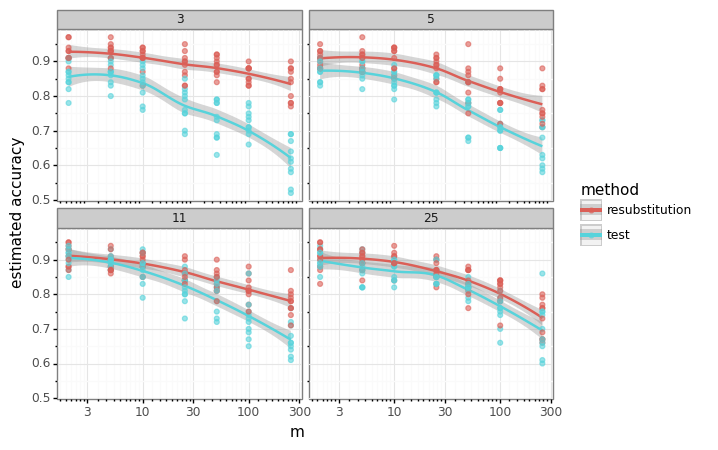

<ggplot: (8763008534670)>


In [36]:
gg = ggplot(ggdata, aes(x="m", y="estimated accuracy", color="method"))
gg += facet_wrap("~k")
gg += stat_smooth()
gg += geom_point(alpha=0.6)
gg += scale_x_log10()
print(gg)

This figure illustrates the degree to which the more flexible (low
$k$) knn models overfit relative to the less flexible (high $k$)
models: the resubstitution accuracy estimate curves lie considerably
above the test accuracy estimate curves for `k=3`, with the
difference between the two curves shrinking considerably as $k$ rises
upwards towards `k=25`.

Cross-Validation 
================

When data are scarce, we'd like to be able to both
1.  build a classifier using a large fraction---close to 100% if
    possible---of the available sampling units, while
2.  assessing classifier performance without suffering
    resubstitution bias.

We know how to handle 2: split the data into training and test sets,
using only training set to build the classifier and only test set for
evaluation of performance. Unfortunately this isn't so great for 1!

One thing we could do with our data split, however, is to swap which
set is used to train and which is used to test. This doesn't
immediately address point 1 above, but it does at least allow us to
use all of our data to test performance.

But we can do better! Why not split our data into three subsets A, B,
and C: we can train on (A+B) and test on C, then train on (A+C) and
test on B, and finally train on (B+C) and test on A. Now we're making
some progress on point 1 above as well as point 2: our training sets
are $\frac{2}{3}$ of our full data set and we end up using 100% of
the data for testing!

This is the key idea of *cross-validation*
([@stone1974cross]), which takes it further to allow for 4-fold,
5-fold, 6-fold, \..., $n$-fold splits of our data set in addition to
the 3-fold split just described. The general idea is to fit a model on
the data from all but one of the subsets and test on the one held-out
subset, repeating this process so that every subset is held-out once.

Performance is generally estimated using this procedure by
-   computing accuracy (or whatever other metric one might prefer)
    separately on each held-out data subset
    -   *using the model fit to the the data from all other
        subsets* so that
    -   in no case is a sampling unit $i$ tested using a fit model for
        which $i$ was part of the training set,
    
-   and then averaging the accuracy estimates from each fold together.

We could code this up from scratch, but it's easier (and less
bug-prone) to use `cross_val_score` provided by the `sklearn`
module `sklearn.model_selection`. Note that unless you want your
cross-validation folds to be split based on the order of the data
specified by your `DataFrame`s, you will have to shuffle the data
yourself prior to cross-validation with `cross_val_score`:

In [37]:
simData = simulate2group(n=100, m=10, mEffected=1, effectSize=2.5)
 ## recall simData is dictionary with pd.DataFrame simData["x"]
 ## and class pd.Series simData["y"]
cvFolds = 5
 ## sklearn wants you to shuffle data set prior to splitting into CV folds!
shuffle = np.random.permutation(len(simData["y"]))
shuffle[0:5]

array([24,  9, 49, 48, 73])

In [38]:
 ## use shuffle to shuffle both simData["x"] and simData["y"]:
simShuffled = {"x" : simData["x"].iloc[shuffle],
               "y" : simData["y"].iloc[shuffle]}
 ## set up sklearn object to handle cv folds:
import sklearn.model_selection as ms
cvScheduler = ms.KFold(n_splits = cvFolds)
 ## now use sklearn.model_selection.cross_val_score to do cross-validation:
cvAccs = ms.cross_val_score(
    estimator = nbr.KNeighborsClassifier(n_neighbors = 5),
    X = simShuffled["x"],   ## shuffled!
    y = simShuffled["y"],   ## shuffled by same shuffle!
    cv = cvScheduler.split(simShuffled["x"])
)
 ## compute average of accuracy estimates from all 5 CV folds:
np.mean(cvAccs)

0.9

Now I'm going to repeat the same many-different-simulations excercise
I did above comparing resubstitution and test set accuracy estimates,
only replace resubstitution with cross-validation using
`cross_val_score`. First I'll set up a function to facilitate this repetition:

In [39]:
def simulateAndCrossValidateKnnModel(n, m, k, mEffected, effectSize, rep,
                                     cvFolds, **kargs):
     ## in case numpy int types have been passed in as arguments:
    n=int(n); m=int(m); k=int(k); mEffected=int(mEffected); rep=int(rep)
    trainSet = simulate2group(n, m, mEffected=mEffected, effectSize=effectSize)
    testSet = simulate2group(n, m, mEffected=mEffected, effectSize=effectSize)
    shuffle = np.random.permutation(len(trainSet["y"]))
    trainShuffled = trainSet["x"].iloc[shuffle]
    trainYShuffled = trainSet["y"].iloc[shuffle]
    cvScheduler = ms.KFold(n_splits=int(cvFolds))
    knnCvAccs = ms.cross_val_score(
        estimator = nbr.KNeighborsClassifier(n_neighbors=k),
        X = trainShuffled,
        y = trainYShuffled,
        cv = cvScheduler.split(trainShuffled)
    )
    cvAccuracyEst = np.mean(knnCvAccs)
    knnFit = nbr.KNeighborsClassifier(n_neighbors=k)\
                .fit(trainSet["x"], trainSet["y"])
    testPredictions = knnFit.predict(testSet["x"])
    test2by2 = pd.crosstab(testPredictions, testSet["y"])
    testAccuracyEst = np.sum(np.diag(test2by2)) / np.sum(np.sum(test2by2))
     ## return vector of results along with simulation parameters:
    return(pd.Series({"m" : m,
                      "k" : k,
                      "rep" : rep,
                      "cv" : cvAccuracyEst,
                      "test" : testAccuracyEst}))

Now, on to list comprehending this function along the rows of
`simulationParameterGrid` (we'll re-use the same one from before)

In [40]:
 ## simulate and model one system / data set per row of simulationParameterGrid
 ## use list comprehension to do this
simulationParameterGrid["cvFolds"] = 5
cvModelingResults = [
    simulateAndCrossValidateKnnModel(**dict(simulationParameterGrid.iloc[i]))
    for i in range(simulationParameterGrid.shape[0])
]
 ## package into pd.DataFrame:
cvModelingResults = pd.concat(cvModelingResults, axis=1).T
cvModelingResults["m"] = cvModelingResults["m"].astype(int)
cvModelingResults["k"] = cvModelingResults["k"].astype(int)
cvModelingResults["rep"] = cvModelingResults["rep"].astype(int)
cvModelingResults.head()

,m,k,rep,cv,test
0,2,3,1,0.88,0.85
1,2,3,2,0.92,0.92
2,2,3,3,0.80,0.82
3,2,3,4,0.79,0.87
4,2,3,5,0.86,0.87


We can use pretty much the same plotting code from before with only
the slightest of modifications:

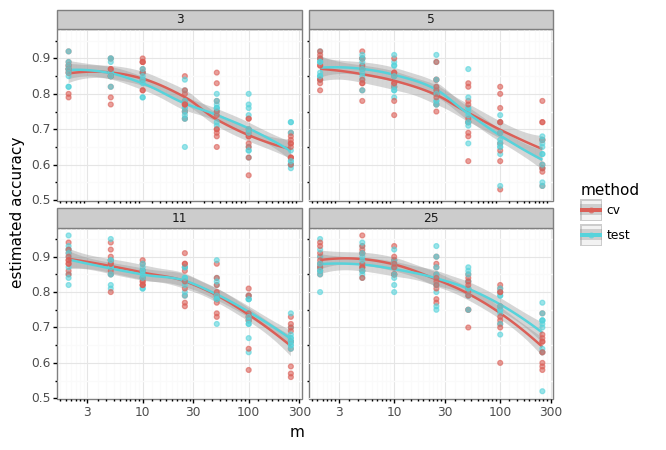

<ggplot: (8763007143057)>


In [41]:
ggdata = cvModelingResults.set_index(["m", "k", "rep"])\
                          .stack()\
                          .reset_index()
ggdata.columns = ["m", "k", "rep", "method", "estimated accuracy"]
gg = ggplot(ggdata, aes(x="m", y="estimated accuracy", color="method"))
gg += facet_wrap("~k")
gg += stat_smooth()
gg += geom_point(alpha=0.6)
gg += scale_x_log10()
print(gg)

Cross-validation works! The cross-validated accuracies are pretty much
in line with the test accuracies.

There is actually a slight *downward* bias in the accuracy
estimates produced by cross-validation resulting from the fact that
our training sets using 5-fold cross-validation are only 80% the size
of the full data set available for training when use the independent
test set. Lest you think that this suggests we should always use the
largest possible number of cross-validation (CV) folds---that is,
$n$---you should know that while increasing the number of CV folds
decreases the negative bias in accuracy estimation, it also increases
the imprecision (variance) in accuracy estimation. As a rule of thumb,
you might consider 5- or 10-fold CV as good default `cvFolds` values.